# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import math

import time
from datetime import timedelta

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm


# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
X_arr = np.array(X_train)
# TODO: number of training examples
n_train = len(X_arr)

# TODO: number of testing examples
n_test = len(np.array(X_test))

# TODO: what's the shape of an image?
#features = tf.placeholder(tf.float32)

image_shape = len(X_arr[0]) * len(X_arr[0][0])

# TODO: how many classes are in the dataset
y_arr = np.array(y_train)
y_unique = np.unique(y_arr)
n_classes = len(y_unique)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 1024
Number of classes = 43


2016-12-01 21:04:22.991857
2016-12-01 21:04:33.598406


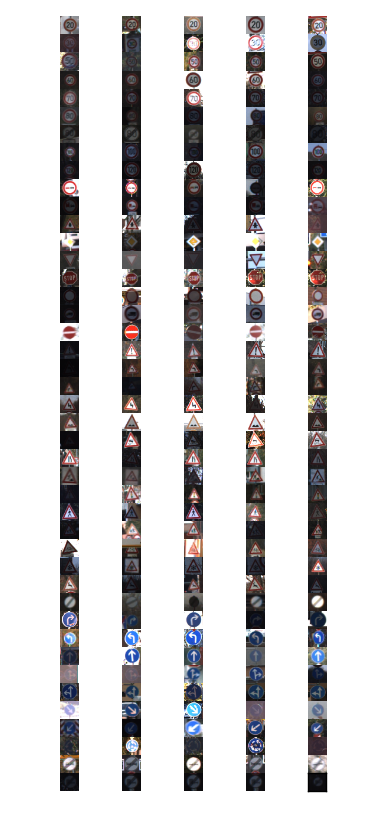

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
from PIL import Image


print(datetime.now())
sample_size = 5 #five images per class label
count = 0 #book keeping for plots

#Set GridSpec
# Rows: Classes (or labels)
# Columns: number of images/class


gspec = gridspec.GridSpec(n_classes, sample_size, wspace=0.0, hspace=0.0)
fig = plt.figure(figsize=(4, 10))

#labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')

for i in range(n_classes):
    ind = y_train == i
    subset_x = X_train[ind,] #get all images that belong to class i
    #print(subset_x)

    for x in range(sample_size):
        img = random.choice(subset_x)
        #print(subset_x.shape)
        #s_plot = plt.subplot(n_classes,sample_size,count) 
        s_plot = plt.Subplot(fig,gspec[count])
        s_plot.set_xticks([])
        s_plot.set_yticks([])
        s_plot.imshow(img, cmap='gray')
        plt.axis('off')
        fig.add_subplot(s_plot)
        #plt.imshow(img)
        count += 1
        result = Image.fromarray(img)
        if count > 214:
            break
       
print(datetime.now()) 
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from tensorflow.python.ops.variables import Variable



#1. Normalize features

# Convert image to grayscale 

def color2gray(image):
   gray = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
   return gray

def pre_process_image(image):
    
    image = color2gray(image)
    return image.flatten()/255.

train_features = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
test_features = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)


In [4]:

# 2. Turn labels into numbers and apply One-Hot Encoding

encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so that it can be multiplied against the features in TensorFlow which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
is_labels_encod = True

print ('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [5]:
#3. Randomize to get validation features and labels set


# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

#print ('Training features and labels randomized and split')

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

features_count = train_features.shape[1]
labels_count = train_labels.shape[1]

print(features_count)
print(labels_count)


features = tf.placeholder(tf.float32, [None, train_features.shape[1]])
labels = tf.placeholder(tf.float32, [None, train_labels.shape[1]])
keep_prob = tf.placeholder(tf.float32) 

train_dict = {features: train_features, labels: train_labels, keep_prob: 0.5}
valid_dict = {features: valid_features, labels: valid_labels, keep_prob: 1.0}
test_dict = {features: test_features, labels: test_labels, keep_prob: 1.0}


#Linear Function WX + b
#logits = tf.matmul(features, weights) + biases

#Hidden Layer

n_hidden_layer = 256 # layer number of features
weights = {
    'hidden_layer_1': tf.Variable(tf.random_normal([features_count, n_hidden_layer])),
    'hidden_layer_2': tf.Variable(tf.random_normal([n_hidden_layer, labels_count])),
}
biases = {
    'hidden_layer_1': tf.Variable(tf.random_normal([n_hidden_layer])),
    'hidden_layer_2': tf.Variable(tf.random_normal([labels_count]))
}

layer_1 = tf.add(tf.matmul(features, weights['hidden_layer_1']), biases['hidden_layer_1'])
layer_1 = tf.nn.relu(layer_1)
layer_1 = tf.nn.dropout(layer_1, keep_prob)
layer_2 = tf.add(tf.matmul(layer_1, weights['hidden_layer_2']), biases['hidden_layer_2'])


prediction = tf.nn.softmax(layer_2)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), 
                                              reduction_indices=[1]))




#Training loss
loss = tf.reduce_mean(cross_entropy)
print ("loss ", loss)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict = train_dict)
    session.run(loss, feed_dict = test_dict)
    biases_data = session.run(biases)
    
#assert not np.count_nonzero(biases_data), 'biases must be zeroes'

print ('Tests passed')

1024
43
loss  Tensor("Mean_1:0", shape=(), dtype=float32)
Tests passed


In [7]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
print ('is_correct_prediction', is_correct_prediction)
#Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
print ('accuracy', accuracy)
print('Accuracy function created')

is_correct_prediction Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy Tensor("Mean_2:0", shape=(), dtype=float32)
Accuracy function created


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

'''
I went through 2 steps of preprocessing my data:

Step 1: Flatten images to grayscale

Rather than modifying the images, I started by flattening them to grayscale. I took the shape of the training 
and testing features and reshaped them into 2-D. Unfortunately, I could not import cv2, so I used an alternative
method to normalize the features.

Step 2: One Hot Endocing

Finally, I applied One-Hot Encoding to the testing and training labels. One-Hot Encoding is a helpful
way to represent our labels mathematically. After applying it, the probabilities for the correct
class are close to 1, while the rest are all 0.


'''

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


'''
To split the data, I first read in the train.p file, and saved the 'features' and 'labels' data 
into X_train and y_train. I did the same thing for test.p. After this, I used the sklearn.model_selection
to import train_test_split and saved parts of the training features and labels into my validation
features and labels, called valid_features and valid_labels.



'''

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

training accuracy at 0.034122638404369354
Validation accuracy at 0.03722590580582619
training accuracy at 0.056378867477178574
Validation accuracy at 0.06221315637230873
training accuracy at 0.04727770760655403
Validation accuracy at 0.05354411154985428
training accuracy at 0.047224011272192
Validation accuracy at 0.05354411154985428
training accuracy at 0.047197163105010986
Validation accuracy at 0.05354411154985428
training accuracy at 0.04708977788686752
Validation accuracy at 0.05354411154985428
training accuracy at 0.04805627092719078
Validation accuracy at 0.05354411154985428
training accuracy at 0.06067439913749695
Validation accuracy at 0.06221315637230873
training accuracy at 0.05742590129375458
Validation accuracy at 0.05303416773676872
training accuracy at 0.06652706116437912
Validation accuracy at 0.0719020888209343
training accuracy at 0.06330541521310806
Validation accuracy at 0.06425293534994125
training accuracy at 0.07315829396247864
Validation accuracy at 0.0836308002

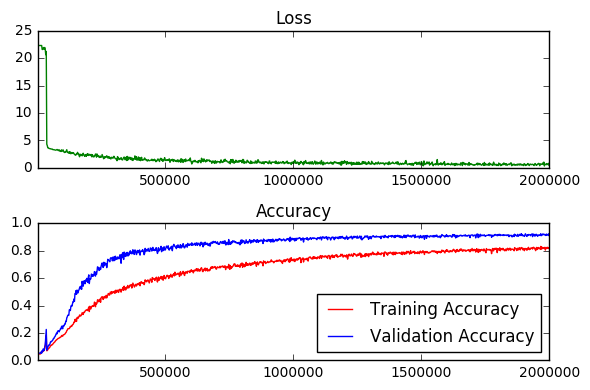

Validation accuracy at 0.9163691997528076
Time usage: 12:40:08


In [8]:
## import tensorflow as tf
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# Parameters
training_epochs = 1000
batch_size = 64
learning_rate = 0.2

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 2000
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

start_time = time.time()

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph

sess = tf.Session()
sess.run(init)
batch_count = int(math.ceil(len(train_features)/batch_size))
# Training cycle
for epoch_i in range(training_epochs):

    # Progress bar
    #batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, training_epochs),unit='batches')

    # The training cycle
    for batch_i in range(1000):
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start+batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]

        # Run optimizer and get loss
        _, l = sess.run([optimizer, loss],feed_dict= {features: batch_features,labels: batch_labels, keep_prob: 0.5})

        # Log every 50 batches
        if not batch_i % log_batch_step:
            # Calculate Training and Validation accuracy
            training_accuracy = sess.run(accuracy, feed_dict=train_dict)
            validation_accuracy = sess.run(accuracy, feed_dict=valid_dict)

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            print('training accuracy at {}'.format(training_accuracy))
            valid_acc_batch.append(validation_accuracy)
            print('Validation accuracy at {}'.format(validation_accuracy))

    # Check accuracy against testing data #change later to check against validation data
    validation_accuracy = sess.run(accuracy, feed_dict=valid_dict)

        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')

acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

        



end_time = time.time()
time_dif = end_time - start_time

print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))








### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [ ]:
'''
I built a deep neural network for my model. To begin, I first tested my model on a linear neural network, similar
to what we had done in our previous lab. I set the features and labels as TensorFlow placeholders, and the weights
and biases TensorFlow variables. I then set up 3 feed_dicts (one for training, testing, and validation), which
would later be inputs to our loss equation.
 
I set up our linear equation, y = WX + b, by doing a matrix multiplication of the features and weights and
adding the biases. This is my logits equation. Next, I used a softmax function to take the scores from
the logits and turn them into probabilities. These probabilities are large when the scores are large, and
small when the scores are small, and sum up to 1. The result of the softmax is stored in prediction.
 
At this point, we have two vectors we can observe, which are our predictions vector, which has the
probabilities from our softmax, and our One-Hot Encoding vector, which corresponds to our labels. The natural
way to measure the distance between these two vectors is by taking the cross-entropy. Once this was done, I
was ready to calculate the loss. My goal was to get low distance when I had the correct class, but a high
distance when I had the incorrect class. To measure this, I took the sum of the distance over the entire training
set, and averaged it over the total size of the training set. My goal was to make sure this loss was very small,
since that would mean our distance was small and our classifier was working. Taking a page out of the lab ,
I then ran a couple of checks on my loss function, to assert it was working well. I was now ready to begin training.
 
 
Over a number of weights, the loss will be large in some areas and small in others, but the goal is to identify the
weights where the loss will be the smallest. By taking the derivative of the loss, with respect to the parameters,
I could get to this minimized loss. To do this, I took the gradient descent of the loss using different learning
rates, using TensorFlow's train.GradientDescentOptimizer function.
 
To set up the neural network, I began by using a basic linear network first. I used a similar layout to our
lab, which took a starting batch of the batch size * the current batch, stored the features and layers into
that batch, and ran the optimizer on that batch. Every 50 batches, I logged the accuracy of the network,
and printed it out throughout my run. However, I was still unable to crack 90% for my validation accuracy
'''

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

In [ ]:
'''

After tinkering with the parameters, I was able to get better results when I used a batch
size of 64, epochs of 100, and learning rate of 0.2. I fiddled with many different combinations, but
while my initial smaller batch size was giving me noiser results, once I increased it to 64, I was able to 
get a better looking graph. One thing I noticed with the epochs was that the more I increased them and 
the more iterations I was able to do over my network, the more variance there was in the accuracies being 
logged. However, when I raised my epochs from 100 to 200, I was able to increase my validation accuracy 
from 87.8% to 89.4%.
 
After verifying my design with a linear network, it was time to add layers to make my network a Deep Neural Network 
(DNN). By adding a Rectified Linear Unit (ReLU) after my main layer, I was able to take my network from linear 
to non-linear, with a new parameter: number of ReLUs. The reason why extra layers improve the network is 
because we can increase efficiency by addressing fewer parameters when we go deeper, instead of wider. 
Another reason is that there are many phenomena we encounter that have hierarchical structure. Thus, 
with more layers, we get closer and closer to detecting an image
when we add more layers. After adding a layer of ReLU, I was able to improve my validation accuracy to 90.5%. 

After this, I figured I could maybe add two more layers to my design, so I experimented by adding another regular
linear layer, followed by a ReLU layer. This actually dropped my accuracy down to 70.1% and made my graph
even noiser. I realized that although adding these layers would help approximate my functions with increased 
non-linearity, it was happening at the cost of overfitting and increased complexity, which may have been resulting
in my model not being able to find the optimal weights. Not to mention, my runtime was increasing because
of the extra layers. 

Finally, I added dropout right at the end of my last layer. The idea of dropout is taking part of the connections 
of the layers, called activations, and setting them to -, therby destroying part of the data. This prevents
overfitting and makes the network act as if it's taking the consensus of networks. This is a common practice
when training DNNs and I applied it to my model hoping for an improvement in my accuracy. Although with my 
previously specifified parameters I actually saw a decrease in performance (83%), I realized that with
this extra layer and dropout added, I needed to add more iterations to compensate for the added complexity
of my model. Thus, after increasing my epochs to 700, I was able to get back to 90%. The downside 
of this was that my runtime increased to 1.5 hours. When I increased, my epochs to 1000, my runtime went up
to 2.5 hours, but my performance went up to almost 92%.


'''

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

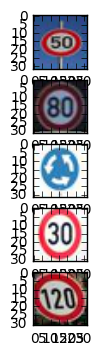

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy import misc


sess.run(tf.add(1,4))
from scipy import misc



g_train = []
g_train.append(misc.imread('german1.jpg'))
g_train.append(misc.imread('german14.jpg'))
g_train.append(misc.imread('german3.jpg'))
g_train.append(misc.imread('german12.jpg'))
g_train.append(misc.imread('german_120.jpg'))


for i, img in enumerate(g_train):
    plt.subplot(5,1,i+1)
    plt.imshow(img)
plt.show()


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



In [ ]:
'''


I fetched 5 images of German traffic signs from the internet. I ran into some problems while trying to resize 
them using numpy, so I resized them manually on my computer All 5 were resized to (32,32,3) pixel arrays 
when read in. I plotted the images to see what they looked like. I confirmed that all of the images were 
equally sized, and the quality of the photos had not been too constrained by the resizing to 32x32, 
since all of them were larger in dimensions previously. My main concern was that in a couple of the images, 
the sign was not the full-on focus of the image. For example, the “20 k/h” sign is on a pole and only really 
takes up 25% of the actual photo, which may make classification a bit more difficult than a 32x32 pixel photo 
of just a square centered sign, such as “120 k/h”


'''

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.


ger_labels = [None] * 5

signname_map = np.genfromtxt('signnames.csv', delimiter=',', usecols=(1,), unpack=True, dtype=str, skip_header = 1)
predictions = y_unique
predict_signNames = []
for id in predictions:
    predict_signNames.append(signname_map[int(id)])
    signname = signname_map[int(id)]
    if(signname == "Speed limit (50km/h)"):
        ger_labels[0] = int(id)
    elif(signname == "Speed limit (80km/h)"):
        ger_labels[1] = int(id)
    elif(signname == "Roundabout mandatory"):
        ger_labels[2] = int(id)
    elif(signname == "Speed limit (30km/h)"):
        ger_labels[3] = int(id)
    elif(signname == "Speed limit (120km/h)"):
        ger_labels[4] = int(id)
    


ger_features = np.array([pre_process_image(g_train[i]) for i in range(len(g_train))],
                          dtype = np.float32)

cold_encode = ger_labels

#print(cold_encode)

ger_labels = encoder.transform(ger_labels)

# Change to float32, so that it can be multiplied against the features in TensorFlow which are float32
ger_labels = ger_labels.astype(np.float32)
is_labels_encod = True

#print(is_labels_encod)

ger_dict = {features: ger_features, labels: ger_labels, keep_prob: 1}
predict_out = sess.run(prediction, ger_dict)
print(predict_out)
correct_prediction = tf.equal(tf.argmax(predict_out,1), tf.argmax(ger_labels,1))
predict_result = sess.run(correct_prediction)
print(predict_result)




[[  5.83348520e-16   7.72507265e-02   7.88676083e-01   9.25867185e-02
    2.89924025e-17   2.08905712e-02   1.18450643e-02   7.95108008e-07
    1.48525226e-15   2.44374326e-10   6.25867713e-09   1.30654001e-07
    2.35194686e-09   2.17577065e-14   2.18791090e-13   2.08533038e-25
    4.40267878e-10   1.97757330e-29   0.00000000e+00   2.52178012e-08
    5.83709294e-08   2.72730366e-19   5.99640129e-33   3.71962088e-08
    2.79053836e-03   9.21153003e-07   0.00000000e+00   6.78983613e-26
    6.21569430e-28   9.04695696e-09   9.09201361e-18   4.82350236e-11
    5.40532183e-19   2.96319831e-05   3.27050493e-08   8.85305508e-06
    7.79252894e-16   1.70100277e-04   5.62507979e-21   6.34378060e-20
    1.50985670e-07   3.95472854e-09   5.74965961e-03]
 [  7.13441147e-14   4.03897957e-11   6.74862954e-19   2.85425776e-05
    2.44638294e-12   9.99971032e-01   3.32822850e-07   4.25553971e-21
    3.93679611e-29   0.00000000e+00   6.07804709e-11   9.50214624e-34
    8.29240800e-27   4.58266460e-20 

In [ ]:
'''

I applied the same preprocessing I had used previously, including flattening and 
grayscaling the images. For storing the labels, I read in the signnames.csv file which 
contained all of the names of the signs, indexed by their label ID. I used a bit of a hack, 
where I blatantly stored the IDs of the 5 signs I had selected by checking the string name 
as I iterated through the full array of signs names, identifying if it was one of my signs, 
and storing it in ger_labels. When I did my one-hot encoding, I made sure to use the same 
binarizer as before, which was already fit to the size of the full labels array (size = 43). 
That way, I ended up with a 5 by 43 matrix, with each row corresponding to one of my 5 labels, 
and each row containing 42 0s and a single 1 at the corresponding ID. 



To observe how my model would perform on these images, I decided to take the softmax function 
from my now fully functional DNN and run it on my new data. Using the same session that was still 
running from my model test, I ran the softmax function and fed in a feed_dict that had my 5 traffic 
signs as the features, and my labels matrix as the labels. Finally, I did a TensorFlow.equal call 
on the argmax of the resulting softmax and the one-hot encoded labels, to see how close my predictions 
were. The result was an array with “True” for the first and third values, but false everywhere else.

I printed out my softmax to observe the results, and noticed that for the resulting values, there 
were always the closest values to 1 were indeed in the correct indices for my 3 of my 5 signs 
(50 km/h, 80 km/h, and 30 km/h). My 120 km/h sign and my roundabout sign did not have values close to 
1 in the correct indicies. However, for my 120 km/h sign, I did have a value of 0.0006 at the 8th index, 
which is the correct index for the 120 km/h sign. Although 0.0006 is not very close to 1, it was much closer 
than the other values.




'''

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.





#print(predict_out)
topFive=tf.nn.top_k(prediction, k=5, sorted=True, name=None)
out = sess.run(topFive, feed_dict = ger_dict)
print(out)

print(cold_encode)



TopKV2(values=array([[  7.88676083e-01,   9.25867185e-02,   7.72507265e-02,
          2.08905712e-02,   1.18450643e-02],
       [  9.99971032e-01,   2.85425776e-05,   3.32822850e-07,
          7.53575051e-08,   6.07804709e-11],
       [  9.94015813e-01,   2.07430916e-03,   1.69554516e-03,
          1.19096658e-03,   4.22750687e-04],
       [  9.87428725e-01,   1.23053892e-02,   8.86502239e-05,
          7.86106393e-05,   7.80804476e-05],
       [  9.83843267e-01,   1.01176938e-02,   4.96190600e-03,
          9.34627315e-04,   6.38691417e-05]], dtype=float32), indices=array([[ 2,  3,  1,  5,  6],
       [ 5,  3,  6, 42, 10],
       [11, 16, 42, 10, 12],
       [ 1,  5,  4,  0, 35],
       [ 4,  0,  1,  5,  8]], dtype=int32))
[2, 5, 40, 1, 8]


**Answer:**

In [ ]:
'''
To test the certainty of the model, I used  tf.nn.top_k to gather the top 5 candidates from 
each resulting softmax row. I created a “top_5” tensor with my softmax, and then ran it in the 
session, giving it my previously defined feed_dict of my 5 signs features and labels as the input. 
The result was what I expected with a pleasant surprise. It did return the top 5 candidates labels 
for each image and sure enough, the #1 candidate was in the correct index for the 3 signs that had 
been correct in my predictions. And although the index for the roundabout was not in the top 5, I 
noticed that 8 was in fact in the top 5 for my 120 km/h image. This actually made 
me feel a sense of relief, because although my model did not find the exact value for this image, it 
did recognize that it was one of the highest candidates. There may be a few reasons why it was not #1 
or that the roundabout image was not even detected in the top 5. First, this may be caused by the quality of images 
that I collected, which really were not perfect. As I mentioned before, the sign in some of my images 
was not as big as in the others and the camera used to take some of the pictures may have not been as 
high quality. Second, my model’s training data may have been less strong for roundabouts, while stronger 
for 50 km/h, which was actually classified correctly. Also, my model itself was not perfect (Performed 
between 91%-92%) and because of the random nature of taking batches while training it, it could have 
been that it just was not trained well enough to detect roundabout signs as it was to detect others. 
This actually occurred to me when I first went through the entire process without dropout, tested on 
these images, and on this test roundabout was detected as the #1 candidate for my roundabout image, as was 50 km/h, 
and all others were not detected. However, on the second run of training, I added more epochs(from 200 -> 1000) and 
added a dropout. The result was that 2 more candidates (30 & 80 km/h) were detected, but roundabout was not!

#Takeaways
All in all, I was content with my results and really enjoyed building my first neural network, training 
it with different parameters, and seeing it work on arbitrary photos. I learned the different tradeoffs 
when dealing with hyper-parameters, and the risks you take when you increase complexity. Most importantly, 
I learned the importance of always setting a validation set of data to test your model on, because as well 
as it performs on your test data, none of it matters if it doesn’t work outside of your sandbox.


'''

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.